# Tau to Nissl registration using color deconvolution


In [1]:
import subprocess
import sys

from deconvolution import Deconvolution
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import SimpleITK as sitk
import skimage
from sklearn.ensemble import RandomForestClassifier


# https://github.com/pyushkevich/histoannot.git
# git clone the GitHub repository and add the path to the sys.path
# This makes sure you are using the latest version of the code
sys.path.append('/Users/cathalye/Packages/histoannot/')
import phas.client.api as phas
from picsl_c3d import Convert3D
from picsl_c3d import Convert2D
from picsl_greedy import Greedy3D
from picsl_greedy import Greedy2D

## Connect to server
User input needed - `PHAS_URL`, `PRIVATE_KEY`

In [2]:
# To get the API key you need to go to https://histo.itksnap.org/auth/api/generate_key
PHAS_URL='https://histo.itksnap.org'
PRIVATE_KEY = '/Users/cathalye/.private/histoitk_api_key.json'

conn = phas.Client(PHAS_URL, PRIVATE_KEY)
proj_listing = pd.DataFrame(conn.project_listing())
proj_listing

,id,admin,disp_name,desc,nslides,nblocks,nspecimens
0,mtl_bf,0,MTL Blockface,Blockface images from the MTL project,28934,81,21
1,mtl,0,MTL Serial Histology,Serially sectioned medial temporal lobe specim...,19248,376,93


In [3]:
task_listing = pd.DataFrame(conn.task_listing('mtl'))
task_listing

,id,name,desc,mode,nspecimens,nblocks,nslides
0,1,Tanglethon 2019,Training a deep learning classifier to recogni...,dltrain,92,356,5214
1,2,Anatomical Labeling - UCLM,Labeling anatomical boundaries and regions by ...,annot,93,376,19248
2,7,Browse,Browse the slide collection,browse,93,376,19248
3,23,Diagnostics,Semiquantiatative rating of selected diagnosti...,dltrain,85,177,876
4,29,Tardython 2022 (TDP-43),Training a deep learning classifier to recogni...,dltrain,75,154,260
5,37,Stereology: Nissl [Deprecated],Stereology for validation of quantitative Niss...,dltrain,89,351,12462
6,38,NISSL stereology sampling ROIs,ROIs for stereology validation,sampling,93,376,19248
7,39,Diagnostic slide sampling,Diagnostic slide sampling,sampling,85,177,876


### Choose task ID
User input needed - `TASK_ID` (choose the id number from `task_listing` dataframe above)

In [4]:
TASK_ID = 39

# Create a task object to pass to Slide class for downloading thumbnails
task = phas.Task(conn, TASK_ID)

# Create a SamplingROITask object for downloading the ROIs as segmentations
samplingROI_task = phas.SamplingROITask(conn, TASK_ID)

## Download source and target slides
User input needed - `SRC_ID`, `TRG_ID` (choose the slide number from the server UI)

In [5]:
REF_ID = 41867 # Tau fixed image
MOV_ID = 43788 # Nissl image with annotations

reference_slide = phas.Slide(task, REF_ID)
reference_slide.thumbnail_nifti_image('reference_thumbnail.nii.gz')

moving_slide = phas.Slide(task, MOV_ID)
moving_slide.thumbnail_nifti_image('moving_thumbnail.nii.gz')
samplingROI_task.slide_sampling_roi_nifti_image(MOV_ID, 'moving_sampling_roi.nii.gz')

# Registration

In [ ]:
# Step 1 - Color deconvolution to get similar looking images

reference_thumbnail = sitk.ReadImage('reference_thumbnail.nii.gz')
moving_thumbnail = sitk.ReadImage('moving_thumbnail.nii.gz')

reference_im = Image.fromarray(sitk.GetArrayFromImage(reference_thumbnail)[0,:,:,:])
decimg = Deconvolution(image=reference_im, sample_density=6)
decimg.complete_basis()
decimg.resolve_dependencies()
reference_layer1, reference_layer2 = decimg.out_images(mode=[1, 2])


AttributeError: module 'SimpleITK' has no attribute 'GetImagefromArray'

In [ ]:
sitk.WriteImage(sitk.GetImageFromArray(reference_layer2), "referece_layer2.nii.gz")

moving_im = Image.fromarray(sitk.GetArrayFromImage(moving_thumbnail)[0,:,:,:])
decimg = Deconvolution(image=moving_im, sample_density=6)
decimg.complete_basis()
decimg.resolve_dependencies()
moving_layer1, moving_layer2 = decimg.out_images(mode=[1, 2])


TypeError: Wrong number or type of arguments for overloaded function 'ImageFileWriter_Execute'.
  Possible C/C++ prototypes are:
    itk::simple::ImageFileWriter::Execute(itk::simple::Image const &)
    itk::simple::ImageFileWriter::Execute(itk::simple::Image const &,itk::simple::PathType const &,bool,int)


(1000, 777, 3)


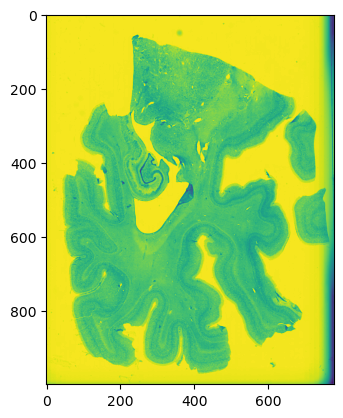

In [21]:
print(np.array(moving_layer2).shape)
plt.imshow(np.array(moving_layer2)[:,:,0])

In [10]:
# Step 2 - Get binanry mask of the reference image

# reference_layer2 = skimage.io.imread('reference_layer2.png')
reference_layer2_gray = skimage.color.rgb2gray(reference_layer2)*255

X, Y = reference_layer2_gray.shape
reference_layer2_gray[0:25, :] = 255
reference_layer2_gray[X-25:X, :] = 255
reference_layer2_gray[:, 0:25] = 255
reference_layer2_gray[:, Y-25:Y] = 255

thresh = skimage.filters.threshold_otsu(reference_layer2_gray)
reference_binary_mask = reference_layer2_gray < thresh

skimage.io.imsave('reference_binary_mask.png', reference_binary_mask)


/var/folders/9p/pb45l8_x16d7c_3jrzkjc79m0000gn/T/ipykernel_71990/1059963404.py:15: UserWarning: reference_binary_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave('reference_binary_mask.png', reference_binary_mask)


In [11]:
# Step 3 - Divide the mask into chunks using image graph cut
# For simplicity, we will define a fixed number of chunks

N_CHUNKS = 10

subprocess.run('image_graph_cut -u 1.2 -n 100 -c 4 0.1 reference_binary_mask.png reference_multi_chunk.nii.gz {}'.format(N_CHUNKS), shell=True)


will generate 10 partitions
   part 0	 weight 0.1
   part 1	 weight 0.1
   part 2	 weight 0.1
   part 3	 weight 0.1
   part 4	 weight 0.1
   part 5	 weight 0.1
   part 6	 weight 0.1
   part 7	 weight 0.1
   part 8	 weight 0.1
   part 9	 weight 0.1
   total of weights : 1

reading input image
Keeping component 1 fraction 0.94917 parts 9
   image has dimensions [783, 1000, 1], nPixels = 783000, nComp = 1
   Breaking component 1 into 9 parts. 
      Initial weights: 0.111111 0.111111 0.111111 0.111111 0.111111 0.111111 0.111111 0.111111 0.111111
      Starting part is: 1
Using K-way algorithm
      Cut value: 892
writing output image


CompletedProcess(args='image_graph_cut -u 1.2 -n 100 -c 4 0.1 reference_binary_mask.png reference_multi_chunk.nii.gz 10', returncode=0)

In [13]:
# Step 4 - Perform global rigid registration

greedy = Greedy2D()

# greedy.execute('-i reference_layer2.png moving_layer2.png '
#                '-a -dof 6 '
#                '-gm reference_binary_mask.png '
#                '-ia-image-centers '
#                '-m WNCC 4x4 -bg NaN -wncc-mask-dilate '
#                '-n 200x200x40x0x0 -search 20000 any 10 '
#                '-o output_global_rigid.mat',
#                )

subprocess.run('greedy -d 2 -a -dof 6 -i referece_layer2.nii.gz moving_layer2.nii.gz -gm reference_binary_mask.nii.gz -ia-image-centers -m WNCC 4x4 -wncc-mask-dilate -n 200x200x40x0x0 -search 20000 any 10 -o output_global_rigid.mat', shell=True)

Executing with the default number of threads: 10
Smooth dir 0 Sigma 1 Dim 3


ABORTING PROGRAM DUE TO RUNTIME EXCEPTION -- /Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/Filtering/ImageFilterBase/include/itkRecursiveSeparableImageFilter.hxx:227:
ITK ERROR: RecursiveGaussianImageFilter(0x11ea0bbb0): The number of pixels along direction 0 is less than 4. This filter requires a minimum of four pixels along the dimension to be processed.


CompletedProcess(args='greedy -d 2 -a -dof 6 -i referece_layer2.nii.gz moving_layer2.nii.gz -gm reference_binary_mask.nii.gz -ia-image-centers -m WNCC 4x4 -wncc-mask-dilate -n 200x200x40x0x0 -search 20000 any 10 -o output_global_rigid.mat', returncode=255)

In [ ]:
# Step 5 - Piecewise rigid registration

output_piecewise_rigid = "output_piecewise_rigid_%02d.mat"
subprocess.run('multi_chunk_greedy -d 2 -a -dof 6 -i reference_layer2.nii.gz moving_layer2.nii.gz -cm reference_multi_chunk.nii.gz -ia output_global_rigid.mat -m WNCC 4x4 -wncc-mask-dilate -n 600x600x200x0 -search 10000 10 5 -wreg 0.05 -o {}'.format(output_piecewise_rigid), shell=True)


1 : 39962   [513, 599]   [757, 881]
2 : 35034   [480, 381]   [731, 614]
3 : 40051   [289, 127]   [625, 449]
4 : 33666   [322, 406]   [534, 749]
5 : 46542   [291, 715]   [757, 974]
6 : 38033   [83, 741]   [324, 974]
7 : 42274   [84, 184]   [345, 468]
8 : 42723   [57, 600]   [396, 788]
9 : 42765   [25, 362]   [384, 626]
Smooth dir 0 Sigma 4 Dim 783
Smooth dir 1 Sigma 4 Dim 1000
Smooth dir 0 Sigma 2 Dim 783
Smooth dir 1 Sigma 2 Dim 1000
Smooth dir 0 Sigma 1 Dim 783
Smooth dir 1 Sigma 1 Dim 1000
Smooth dir 0 Sigma 4 Dim 783
Smooth dir 1 Sigma 4 Dim 1000
Smooth dir 0 Sigma 2 Dim 783
Smooth dir 1 Sigma 2 Dim 1000
Smooth dir 0 Sigma 1 Dim 783
Smooth dir 1 Sigma 1 Dim 1000
Smooth dir 0 Sigma 4 Dim 783
Smooth dir 1 Sigma 4 Dim 1000
Smooth dir 0 Sigma 2 Dim 783
Smooth dir 1 Sigma 2 Dim 1000
Smooth dir 0 Sigma 1 Dim 783
Smooth dir 1 Sigma 1 Dim 1000
Smooth dir 0 Sigma 4 Dim 783
Smooth dir 1 Sigma 4 Dim 1000
Smooth dir 0 Sigma 2 Dim 783
Smooth dir 1 Sigma 2 Dim 1000
Smooth dir 0 Sigma 1 Dim 783
Sm

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-5.4420752100060  1.0067720375103 -0.0438018333245  0.7782330213663  0.0433553746780  0.9990573092535 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-0.0225791345284  1.0024119859731 -0.1034462983032 -0.2824996067629  0.1023919019272  0.9947306680730 
             nan              nan              n

 nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
 IFLAG= -1  LINE SEARCH FAILED. SEE DOCUMENTATION OF ROUTINE MCSRCH ERROR RETURN OF LINE SEARCH: INFO= 3 POSSIBLE CAUSES: FUNCTION OR GRADIENT ARE INCORRECT OR INCORRECT TOLERANCESDerivative check:
0:      nan       nan
1:      nan       nan
2:      nan       nan
3:      nan       nan
4:      nan       nan
5:      nan       nan
6:      nan       nan
7:      nan       nan
8:      nan       nan
9:      nan       nan
10:      nan       nan
11:      nan       nan
12:      nan       nan
13:      nan       nan
14:      nan       nan
15:      nan       nan
16:      nan       nan
17:      nan       nan
18:      nan       nan
19:      nan       nan
20:      nan

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.1316857141441  1.0043191450320 -0.0828504635747  1.2239391336976  0.0820059942223  0.9966232128861 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.4026843328526  1.0038221505532 -0.0886836249735 -1.8947726837877  0.0877796999968  0.9961300267942 
             nan              nan              n

 nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-58.4989839574626  0.8877796528721  0.4664437329564 69.2265129133400 -0.4640570531415  0.8854945731093 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-10.8127496265840  1.0016354454821 -0.0435783545830  1.5352597007668  0.0433553746780  0.9990573092535 
             nan              nan             

 nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-34.0158225700293  0.9787949673486  0.2173675791841 28.3874123925158 -0.2162553618318  0.9762756208367 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-58.4989839574626  0.8877796528721  0.4664437329564 69.2265129133400 -0.4640570531415  0.8854945731093 
             nan              nan             

 nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
 IFLAG= -1  LINE SEARCH FAILED. SEE DOCUMENTATION OF ROUTINE MCSRCH ERROR RETURN OF LINE SEARCH: INFO= 3 POSSIBLE CAUSES: FUNCTION OR GRADIENT ARE INCORRECT OR INCORRECT TOLERANCESDerivative check:
0:      nan       nan
1:      nan       nan
2:      nan       nan
3:      nan       nan
4:      nan       nan
5:      nan       nan
6:      nan       nan
7:      nan       nan
8:      nan       nan
9:      nan       nan
10:      nan       nan
11:      nan       nan
12:      nan       nan
13:      nan       nan
14:      nan       nan
15:      nan       nan
16:      nan       nan
17:      nan       nan
18:      nan       nan
19:      nan       nan
20:      nan       nan
21:      nan       nan
22:      nan       nan
23:      nan       nan
24:      nan       nan
25:      nan       nan
26:      nan       nan
27

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-35.9944456952233  0.9796115149534  0.2136479466812 32.7491941352570 -0.2125547617892  0.9770900667078 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
90.8888220760719  0.7701788276149 -0.6426860710007 -28.8337225696380  0.6393976017500  0.7681964437576 
             nan              nan             

NCC: -0.280 -0.337 -0.065 -0.097 -0.067 -0.117 -0.032 -0.121 -0.030 Reg:   nan  Tot:   nan
*************************************************
  N=36   NUMBER OF CORRECTIONS=5       INITIAL VALUES F= nan   GNORM= nan
*************************************************
   I   NFN    FUNC        GNORM       STEPLENGTH
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-21.5504136247749  0.9990671494681 -0.0434666152123  3.0493130595678  0.0433553746780  0.9990573092535 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.0569397650978  0.9947404656723 -0.1026546174489 -1.2756822820519  0.1023919019272  0.9947306680730 
             nan              nan              

 nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.6357806009643  0.9966330291261 -0.0822164039045  4.7778127241277  0.0820059942223  0.9966232128861 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 1.7209017659257  0.9961398381765 -0.0880049237620 -7.7049553253372  0.0877796999968  0.9961300267942 
             nan              nan              n

 nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-46.7308447373847  0.9980460338864  0.0627203495830 20.6071364549285 -0.0625598345495  0.9980362037291 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-71.9019685030043  0.9770996905561  0.2131001314333 65.6161206180547 -0.2125547617892  0.9770900667078 
             nan              nan             

 nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
181.7454006000577  0.7682040101082 -0.6410381579981 -57.8712421620297  0.6393976017500  0.7681964437576 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-67.9563168584191  0.9762852366631  0.2168102264170 56.8948146555291 -0.2162553618318  0.9762756208367 
             nan              nan            

 nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-67.9563168584191  0.9762852366631  0.2168102264170 56.8948146555291 -0.2162553618318  0.9762756208367 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-116.8759127370501  0.8855032947878  0.4652477233847 138.7423070666962 -0.4640570531415  0.8854945731093 
             nan              nan           

 nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-67.9563168584191  0.9762852366631  0.2168102264170 56.8948146555291 -0.2162553618318  0.9762756208367 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-116.8759127370501  0.8855032947878  0.4652477233847 138.7423070666962 -0.4640570531415  0.8854945731093 
             nan              nan           

 nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-21.5504136247749  0.9990671494681 -0.0434666152123  3.0493130595678  0.0433553746780  0.9990573092535 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.0569397650978  0.9947404656723 -0.1026546174489 -1.2756822820519  0.1023919019272  0.9947306680730 
             nan              nan              

 nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan 

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 0.6357806009643  0.9966330291261 -0.0822164039045  4.7778127241277  0.0820059942223  0.9966232128861 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
 1.7209017659257  0.9961398381765 -0.0880049237620 -7.7049553253372  0.0877796999968  0.9961300267942 
             nan              nan              n

 nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
NCC:  nan  nan  nan  nan  nan  nan  nan  nan  nan Reg:   nan  Tot:   nan
 IFLAG= -1  LINE SEARCH FAILED. SEE DOCUMENTATION OF ROUTINE MCSRCH ERROR RETURN OF LINE SEARCH: INFO= 3 POSSIBLE CAUSES: FUNCTION OR GRADIENT ARE INCORRECT OR INCORRECT TOLERANCES

/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-46.7308447373847  0.9980460338864  0.0627203495830 20.6071364549285 -0.0625598345495  0.9980362037291 
             nan              nan              nan              nan              nan              nan 
             nan              nan              nan              nan              nan              nan  ]
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: suspicious return value (4) from SVDC
/Users/pauly/tk/buildbot/Nightly/itk/v5.2.1/itk/Modules/ThirdParty/VNL/src/vxl/core/vnl/algo/vnl_svd.hxx: M is 3x6
M = [ ...
-71.9019685030043  0.9770996905561  0.2131001314333 65.6161206180547 -0.2125547617892  0.9770900667078 
             nan              nan             

CompletedProcess(args='multi_chunk_greedy -d 2 -a -dof 6 -i reference_layer2.png moving_layer2.png -cm reference_multi_chunk.nii.gz -ia output_global_rigid.mat -m WNCC 4x4 -wncc-mask-dilate -n 600x600x200x0 -search 10000 10 5 -wreg 0.05 -o output_piecewise_rigid_%02d.mat', returncode=0)

In [ ]:
# Step 6 - Piecewise deformable registration

output_piecewise_deformable = "output_piecewise_deformable_%02d.nii.gz"
subprocess.run('multi_chunk_greedy -d 2 -i reference_layer2.nii.gz moving_layer2.nii.gz -cm reference_multi_chunk.nii.gz -it {} -m WNCC 4x4 -wncc-mask-dilate -n 400x200x100x20 -sv -s 0.6mm 0.1mm -e 0.25 -o {}'.format(output_piecewise_rigid, output_piecewise_deformable), shell=True)

1 : 39962   [513, 599]   [757, 881]
2 : 35034   [480, 381]   [731, 614]
3 : 40051   [289, 127]   [625, 449]
4 : 33666   [322, 406]   [534, 749]
5 : 46542   [291, 715]   [757, 974]
6 : 38033   [83, 741]   [324, 974]
7 : 42274   [84, 184]   [345, 468]
8 : 42723   [57, 600]   [396, 788]
9 : 42765   [25, 362]   [384, 626]
Smooth dir 0 Sigma 4 Dim 783
Smooth dir 1 Sigma 4 Dim 1000
Smooth dir 0 Sigma 2 Dim 783
Smooth dir 1 Sigma 2 Dim 1000
Smooth dir 0 Sigma 1 Dim 783
Smooth dir 1 Sigma 1 Dim 1000
LEVEL 1 of 4
  Smoothing sigmas (mm): 4.800000x4.800000 0.800000x0.800000
Level 000  Iter 00000  Metrics  0.193610  0.194854  0.138702  Energy = 0.527166
Level 000  Iter 00001  Metrics  0.199297  0.200576  0.144408  Energy = 0.544281
Level 000  Iter 00002  Metrics  0.205965  0.207293  0.151125  Energy = 0.564383
Level 000  Iter 00003  Metrics  0.212434  0.213810  0.157687  Energy = 0.583931
Level 000  Iter 00004  Metrics  0.218731  0.220155  0.164102  Energy = 0.602988
Level 000  Iter 00005  Metric

CompletedProcess(args='multi_chunk_greedy -d 2 -i reference_layer2.png moving_layer2.png -cm reference_multi_chunk.nii.gz -it output_piecewise_rigid_%02d.mat -m WNCC 4x4 -wncc-mask-dilate -n 400x200x100x20 -sv -s 0.6mm 0.1mm -e 0.25 -o output_piecewise_deformable_%02d.nii.gz', returncode=0)

In [13]:
# Step 7 - Apply the piecewise rigid and deformable registration to the moving image

subprocess.run('multi_chunk_greedy -d 2 -rf reference_thumbnail.nii.gz -cm reference_multi_chunk.nii.gz -r {} {} -rb 255 -rm moving_thumbnail.nii.gz moving_deform.nii.gz'.format(output_piecewise_deformable, output_piecewise_rigid), shell=True)

1 : 39962   [513, 599]   [757, 881]
2 : 35034   [480, 381]   [731, 614]
3 : 40051   [289, 127]   [625, 449]
4 : 33666   [322, 406]   [534, 749]
5 : 46542   [291, 715]   [757, 974]
6 : 38033   [83, 741]   [324, 974]
7 : 42274   [84, 184]   [345, 468]
8 : 42723   [57, 600]   [396, 788]
9 : 42765   [25, 362]   [384, 626]


CompletedProcess(args='multi_chunk_greedy -d 2 -rf reference_thumbnail.nii.gz -cm reference_multi_chunk.nii.gz -r output_piecewise_deformable_%02d.nii.gz output_piecewise_rigid_%02d.mat -rb 255 -rm moving_thumbnail.nii.gz moving_deform.nii.gz', returncode=0)